In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

import skimage.transform
import skimage.util
from skimage.io import imread

#from preprocessing import preprocess_image

# machine learning packages
import tensorflow as tf

########
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
#from keras import  backend as K
from tensorflow.keras import backend as k
from tensorflow.keras.preprocessing.image import ImageDataGenerator
##########

#from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.layers import BatchNormalization, Convolution2D
#from keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
#from keras.preprocessing import image
#from keras.utils import layer_utils
#from keras.utils.data_utils import get_file
#from keras.applications.imagenet_utils import preprocess_input
#import pydot
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model
#from kt_utils import *
from tensorflow.keras import optimizers
import preprocessing

### Changed to Keras.something to tensorflow.keras.something to avoid the error the backend issues.
### There were conflicting issues with Tensorflow 2.0 and keras

### Load the train and test data

In [3]:
# reading training data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

Each row is a 784 pixels, can be written into 28$\times$28 matrix which represents a digit. Let's drop the first column in order to read rows for digits.

Labels varies from 0 to 9.

In [4]:
X_train_orig = (train.iloc[:,1:].values).astype('float32') # all rows
Y_train_orig = train.iloc[:,0].values.astype('int32') # all labels
X_test_orig = test.values.astype('float32')

Split the data into train and validation datasets

In [5]:
batch_size=64
X_train, X_val, Y_train, Y_val = train_test_split(X_train_orig, Y_train_orig, test_size=0.10, random_state=56)
Y_train=Y_train.astype('int32')
Y_val=Y_val.astype('int32')

In [ ]:
X_train = X_train[0:3000]
Y_train = Y_train[0:3000]
X_val = X_val[0:300]
Y_val = Y_val[0:300]

### Data Visualization

In [6]:
# To convert train dataset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test_orig.reshape(X_test_orig.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28,1 )

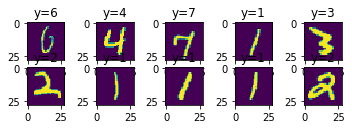

In [7]:
## printing random hand-written digits
indx = np.random.randint(0,len(X_train)-1,size=10)
fig = plt.figure()
for ix in range(10):
    ax = fig.add_subplot(5, 5, 1 + ix)
    ax.imshow(X_train[indx[ix],:,:,0])
    ax.set_title('y='+str(Y_train[indx[ix]]))

In [8]:
## reducing the pixels values between 0 and 1
Xn_train = X_train/255.
Xn_test = X_test/255.
Xn_val = X_val/255.

### One-hot encoding

In [ ]:
#def convert_to_one_hot(Y, C):
#    Y = np.eye(C)[Y.reshape(-1)].T
#    return Y
#Y_train = convert_to_one_hot(Y_train, 10).T
#Y_val = convert_to_one_hot(Y_val, 10).T

In [9]:
Ye_train= to_categorical(Y_train)
Ye_val= to_categorical(Y_val)
nlabels = Ye_train.shape[1]
print('Total number of different labels',nlabels)

Total number of different labels 10


### Linear Model

In [ ]:
def LinearModel(input_shape):
    """
    Implementation of the LinearModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X_input)
    X = Dense(10, activation='softmax', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='LinearModel')
    return model

In [ ]:
def lm_run(Model,xdata,ydata,xval,yval,bs):
    model = Model(Xn_train[-1].shape)
    model.compile(optimizers.Adam(lr=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(x = Xn_train, y = Ye_train, epochs = 40, batch_size = 64)
    mval =  model.evaluate(x = xval, y = yval)
    return mval,history

In [ ]:
val,his=lm_run(LinearModel,Xn_train,Ye_train, Xn_val, Ye_val,64)

In [ ]:
# Plot training & validation accuracy values
plt.plot(his.history['accuracy'])
plt.scatter(40,val[1])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(his.history['loss'])
plt.scatter(40,val[0])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Convulational Model

In [ ]:
def ConvModel(input_shape):
    """
    Implementation of the ConvModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(10, activation='softmax', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='ConvModel')
    return model

In [ ]:
val,his=lm_run(ConvModel,Xn_train,Ye_train, Xn_val, Ye_val,64)

In [ ]:
# Plot training & validation accuracy values
plt.plot(his.history['accuracy'])
plt.scatter(40,val[1])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(his.history['loss'])
plt.scatter(40,val[0])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Kurapan CNN_MNIST

In [10]:
def TestConvModel(input_shape):
    """
    Implementation of the ConvModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)
    
    # 
    X = ZeroPadding2D((2, 2))(X_input)
    X = Conv2D(64,5,5,kernel_initializer='he_normal',padding='same')(X)
    X = Activation('relu')(X)
    X = ZeroPadding2D((2, 2))(X)
    X = Conv2D(128,5,5,kernel_initializer='he_normal',padding='same')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(strides=(2, 2),padding='same')(X)
   
    #
    X = ZeroPadding2D((2, 2))(X)
    X = Conv2D(256,5,5,kernel_initializer='he_normal',padding='same')(X)
    X = Activation('relu')(X)
    X = ZeroPadding2D((1, 1))(X)
    X = Conv2D(256,3,3,kernel_initializer='he_normal',padding='same')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(strides=(2, 2),padding='same')(X)
    X = Dropout(0.2)(X)
    
    #
    X = ZeroPadding2D((1, 1))(X)
    X = Conv2D(512,2,3,kernel_initializer='he_normal',padding='same')(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    X = ZeroPadding2D((1, 1))(X)
    X = Conv2D(512,3,3,kernel_initializer='he_normal',padding='same')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(strides=(2, 2),padding='same')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    X = Dense(2048, activation='relu', kernel_initializer='he_normal')(X)

    predictions = Dense(10, activation="softmax")(X)
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = predictions, name='ConvModel')
    return model

In [11]:
def rotation_and_shear(img, rotation_angle=15, shear_angle=30):
    img = skimage.transform.rotate(img, np.random.randint(-rotation_angle, rotation_angle))
    tf_shift = skimage.transform.SimilarityTransform(translation=(-14, -14))
    tf_inv_shift = skimage.transform.SimilarityTransform(translation=(14, 14))
    tf_shear = skimage.transform.AffineTransform(shear=np.deg2rad(np.random.randint(-shear_angle, shear_angle)))
    img = skimage.transform.warp(img, (tf_shift + (tf_shear + tf_inv_shift)).inverse)
    return img

In [12]:
def shift_pixels(img, shift_range=1):
    tf_shift = skimage.transform.SimilarityTransform(translation=(np.random.randint(-shift_range, shift_range), np.random.randint(-shift_range, shift_range)))
    img = skimage.transform.warp(img, tf_shift)
    return img

In [13]:
def add_noise(img, gauss_var=0.02):
    #img = skimage.util.random_noise(img, mode='pepper', amount=0.1)
    img = skimage.util.random_noise(img, mode='gaussian', var=gauss_var)
    return img

In [14]:
def batch_generator(trainX, trainY, batch_size):
    trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1],trainX.shape[2])
    while True:
        idxs = np.arange(0, trainY.shape[0])
        np.random.shuffle(idxs)
        for i in range(trainY.shape[0] // batch_size):
            batchX = [trainX[idx] for idx in idxs[i * batch_size : (i+1) * batch_size]]
            batchY = [trainY[idx] for idx in idxs[i * batch_size : (i+1) * batch_size]]
            batchX = [add_noise(rotation_and_shear(img[0])) for img in batchX]
            batchX = np.array(batchX)
            batchX = batchX.reshape(batchX.shape[0], batchX.shape[1], batchX.shape[2], 1)
            #return batchX, batchY
            yield batchX, np.array(batchY)

In [45]:
def run(Model,xdata,ydata,xval,yval,xtest,bs,nb):
    #xdata = xdata.reshape(xdata.shape[0],1,xdata.shape[1],xdata.shape[2])
    model = Model(xdata[-1].shape)
    model.compile(optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss="categorical_crossentropy", metrics=["accuracy"])
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    # reduce the learning rate by factor of 0.5 if the validation loss does not get lower in 7 epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.0000001, verbose=1)
    history = model.fit_generator(batch_generator(xdata, ydata, batch_size=bs),steps_per_epoch=np.ceil(ydata.shape[0] / bs),validation_data=(xval, yval),epochs=nb, verbose=1, callbacks=[reduce_lr])
    ##history = model.fit(x = xdata, y = ydata, epochs = 40, batch_size = bs,validation_data= (xval,yval),callbacks=[es])
    mval =  model.evaluate(x = xval, y = yval)
    ytest=model.predict(xtest)
    return mval,history,ytest

In [ ]:
testx,testy=batch_generator(Xn_train, Ye_train, 64)

In [ ]:
Xn_train.shape

In [46]:
val,his,ypred=run(TestConvModel,Xn_train,Ye_train, Xn_val, Ye_val,Xn_test,64,70)

Epoch 1/70
591/591 [==============================] - 256s 434ms/step - loss: 0.6310 - accuracy: 0.7989 - val_loss: 0.1846 - val_accuracy: 0.9495
Epoch 2/70
591/591 [==============================] - 254s 430ms/step - loss: 0.2674 - accuracy: 0.9244 - val_loss: 0.1274 - val_accuracy: 0.9621
Epoch 3/70
591/591 [==============================] - 239s 405ms/step - loss: 0.2104 - accuracy: 0.9433 - val_loss: 0.1041 - val_accuracy: 0.9679
Epoch 4/70
591/591 [==============================] - 237s 401ms/step - loss: 0.1824 - accuracy: 0.9501 - val_loss: 0.1253 - val_accuracy: 0.9705
Epoch 5/70
591/591 [==============================] - 239s 404ms/step - loss: 0.1640 - accuracy: 0.9557 - val_loss: 0.1010 - val_accuracy: 0.9712
Epoch 6/70
591/591 [==============================] - 238s 403ms/step - loss: 0.1450 - accuracy: 0.9599 - val_loss: 0.0908 - val_accuracy: 0.9771
Epoch 7/70
591/591 [==============================] - 238s 402ms/step - loss: 0.1393 - accuracy: 0.9620 - val_loss: 0.0855 -

591/591 [==============================] - 236s 400ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.0447 - val_accuracy: 0.9902
Epoch 52/70
591/591 [==============================] - 236s 399ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0460 - val_accuracy: 0.9898
Epoch 53/70
591/591 [==============================] - 239s 404ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0443 - val_accuracy: 0.9914
Epoch 54/70
591/591 [==============================] - 238s 403ms/step - loss: 0.0249 - accuracy: 0.9921 - val_loss: 0.0452 - val_accuracy: 0.9914
Epoch 55/70
591/591 [==============================] - 237s 402ms/step - loss: 0.0247 - accuracy: 0.9920 - val_loss: 0.0474 - val_accuracy: 0.9910
Epoch 56/70
591/591 [==============================] - 237s 401ms/step - loss: 0.0255 - accuracy: 0.9923 - val_loss: 0.0456 - val_accuracy: 0.9912
Epoch 57/70
590/591 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 0.9916
Epoch 00057: ReduceLROnPlateau re

In [17]:
base_model = TestConvModel(Xn_train[-1].shape)
base_model.summary()

Model: "ConvModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          1664      
_________________________________________________________________
activation_6 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 128)         204928    
_________________________________________________________________
activation_7 (Activation)    (None, 3, 3, 128)         0 

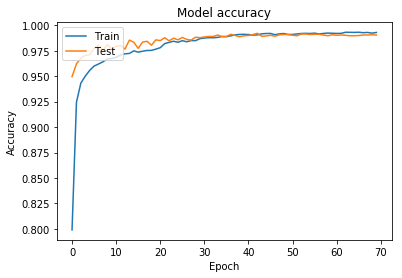

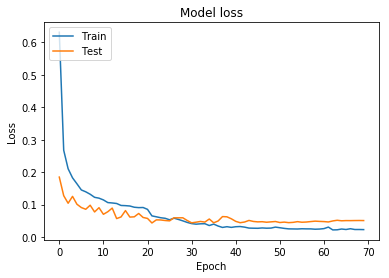

In [47]:
# Plot training & validation accuracy values
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [58]:
(his.history['loss'][30]-his.history['val_loss'][30])/his.history['loss'][30] * 100

-5.814500582928663

In [59]:
his.history['accuracy'][30]

0.9875212

In [ ]:
Xn_test.shape

In [35]:
ytest=np.argmax(ypred,axis=1)

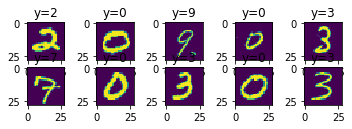

In [41]:
## printing random hand-written digits
indx = np.arange(len(Xn_test)) #np.random.randint(0,len(Xn_test)-1,size=10)
fig = plt.figure()
for ix in range(10):
    ax = fig.add_subplot(5, 5, 1 + ix)
    ax.imshow(Xn_test[indx[ix],:,:,0])
    ax.set_title('y='+str(ytest[indx[ix]]))

In [40]:
image_id = np.arange(len(Xn_test))
submission = pd.DataFrame({
        "ImageId": image_id,
        "Label": ytest
    })
submission.to_csv('submission.csv', index=False)

In [29]:
def Lenet5Model(input_shape):
    """
    Implementation of the ConvModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)
    
    # 
    X = ZeroPadding2D((2, 2))(X_input)
    print(np.shape(X))
    X = Conv2D(6,5,1,kernel_initializer='he_normal')(X)
    print(np.shape(X))
    X = AveragePooling2D(pool_size=(2,2),strides=2)(X)
    print(np.shape(X))
    X = Conv2D(16,5,1,kernel_initializer='he_normal')(X)
    print(np.shape(X))
    X = AveragePooling2D(pool_size=(2,2),strides=2)(X)
    print(np.shape(X))
    X = Flatten()(X)
    print(np.shape(X))
    X = Dense(120, activation='relu', kernel_initializer='he_normal')(X)
    print(np.shape(X))
    X = Dense(84, activation='relu', kernel_initializer='he_normal')(X)
    print(np.shape(X))
    predictions = Dense(10, activation="softmax")(X)
    print(np.shape(predictions))
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = predictions, name='Lenet5Model')
    return model

In [34]:
lval,lhis,lypred=run(Lenet5Model,Xn_train,Ye_train, Xn_val, Ye_val,Xn_test,64,300)

(None, 32, 32, 1)
(None, 28, 28, 6)
(None, 14, 14, 6)
(None, 10, 10, 16)
(None, 5, 5, 16)
(None, 400)
(None, 120)
(None, 84)
(None, 84)
Epoch 1/300
591/591 [==============================] - 21s 36ms/step - loss: 0.4312 - accuracy: 0.8646 - val_loss: 0.1839 - val_accuracy: 0.9469
Epoch 2/300
591/591 [==============================] - 20s 34ms/step - loss: 0.2280 - accuracy: 0.9297 - val_loss: 0.1360 - val_accuracy: 0.9619
Epoch 3/300
591/591 [==============================] - 20s 34ms/step - loss: 0.1825 - accuracy: 0.9426 - val_loss: 0.1100 - val_accuracy: 0.9662
Epoch 4/300
591/591 [==============================] - 20s 34ms/step - loss: 0.1560 - accuracy: 0.9510 - val_loss: 0.1059 - val_accuracy: 0.9724
Epoch 5/300
591/591 [==============================] - 21s 35ms/step - loss: 0.1399 - accuracy: 0.9565 - val_loss: 0.1193 - val_accuracy: 0.9669
Epoch 6/300
591/591 [==============================] - 20s 34ms/step - loss: 0.1329 - accuracy: 0.9570 - val_loss: 0.0999 - val_accuracy: 0

Epoch 53/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0346 - accuracy: 0.9881 - val_loss: 0.0581 - val_accuracy: 0.9843
Epoch 54/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0338 - accuracy: 0.9887 - val_loss: 0.0556 - val_accuracy: 0.9845
Epoch 55/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0362 - accuracy: 0.9880 - val_loss: 0.0555 - val_accuracy: 0.9857
Epoch 56/300
591/591 [==============================] - 20s 35ms/step - loss: 0.0338 - accuracy: 0.9884 - val_loss: 0.0578 - val_accuracy: 0.9855
Epoch 57/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0337 - accuracy: 0.9889 - val_loss: 0.0560 - val_accuracy: 0.9848
Epoch 58/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0363 - accuracy: 0.9879 - val_loss: 0.0568 - val_accuracy: 0.9843
Epoch 59/300
590/591 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9884
Epoch 00059: ReduceLROnPla

Epoch 102/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0328 - accuracy: 0.9887 - val_loss: 0.0578 - val_accuracy: 0.9850
Epoch 103/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0309 - accuracy: 0.9900 - val_loss: 0.0578 - val_accuracy: 0.9850
Epoch 104/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0318 - accuracy: 0.9893 - val_loss: 0.0578 - val_accuracy: 0.9850
Epoch 105/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0329 - accuracy: 0.9891 - val_loss: 0.0578 - val_accuracy: 0.9850
Epoch 106/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0342 - accuracy: 0.9890 - val_loss: 0.0578 - val_accuracy: 0.9850
Epoch 107/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0307 - accuracy: 0.9900 - val_loss: 0.0577 - val_accuracy: 0.9850
Epoch 108/300
589/591 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9889
Epoch 00108: Reduce

Epoch 151/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0315 - accuracy: 0.9889 - val_loss: 0.0579 - val_accuracy: 0.9848
Epoch 152/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0314 - accuracy: 0.9898 - val_loss: 0.0579 - val_accuracy: 0.9848
Epoch 153/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.0579 - val_accuracy: 0.9848
Epoch 154/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0317 - accuracy: 0.9891 - val_loss: 0.0579 - val_accuracy: 0.9848
Epoch 155/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0312 - accuracy: 0.9898 - val_loss: 0.0579 - val_accuracy: 0.9848
Epoch 156/300
591/591 [==============================] - 20s 34ms/step - loss: 0.0327 - accuracy: 0.9893 - val_loss: 0.0579 - val_accuracy: 0.9848
Epoch 157/300
589/591 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9894
Epoch 00157: Reduce

KeyboardInterrupt: 

In [38]:
np.shape(Xn_test)

(28000, 28, 28, 1)